In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from flash_attn import flash_attn_func

from library import StockUniverse, FactorLibrary, MarketInfo, FileLoader
import pandas as pd
from torch.utils.data import Dataset
import numpy as np
import gc
import torch
from torch.utils.data import DataLoader
from library import FactorLibrary2
import gc


📂 讀取: Y:\因子回測_江建彰\因子庫.pkl


In [2]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import TimeSeriesSplit

In [3]:
stock_universe = 'TWSE'
flib = FactorLibrary2(path=f'Y:\因子回測_江建彰\因子庫{stock_universe}.pkl')

📂 讀取: Y:\因子回測_江建彰\因子庫TWSE.pkl


In [4]:
class AllDayFactorDataset(Dataset):
    def __init__(self, stock_universe='TWSE'):
        self.multi_df = FileLoader.load(f'Y:\因子回測_江建彰\因子庫{stock_universe}.pkl')
        self.adj_close_df = pd.read_feather(r'Y:\因子回測_江建彰\補上缺值日頻收盤價.ftr')
        self.stock_list = self.get_stock_list(stock_universe)
        
        self.TPEX_df = MarketInfo.TPEX_norm()
        self.RoR_df = (self.adj_close_df.shift(-5) - self.adj_close_df.shift(-1)) / self.adj_close_df.shift(-1)
        self.RoR_df.dropna(axis=0, inplace=True)


        new_ticker_list = self.multi_df.columns.get_level_values('ticker')
        new_ticker_list = new_ticker_list[~new_ticker_list.duplicated()]

        self.stock_list = new_ticker_list
        self.RoR_df = self.RoR_df[self.stock_list]
        self.adj_close_df = self.adj_close_df[self.stock_list]
        # 這裡所有值都包含當天資訊所以要向後移
        self.restrict_range()
        self.check_validility()

    def check_validility(self):
        ticker_list1 = self.stock_list
        ticker_list2 = self.RoR_df.columns
        ticker_list3 = self.multi_df.columns.get_level_values('ticker')
        ticker_list3 = ticker_list3[~ticker_list3.duplicated()]
        assert len(ticker_list1)==len(ticker_list2)==len(ticker_list3)
        
        BOOL = True
        for i in range(len(ticker_list1)):
            if not (ticker_list1[i]==ticker_list2[i]==ticker_list3[i]):
                BOOL = False
        assert BOOL==True
        

        factor_list = self.multi_df.columns.get_level_values('factor')
        factor_list = factor_list[~factor_list.duplicated()]
        BOOL = True
        for factor_name in factor_list:
            ticker_list4 = self.multi_df.loc[ : , factor_name].columns
            for i in range(len(ticker_list1)):
                if ticker_list1[i]!=ticker_list4[i]:
                    BOOL = False
        assert BOOL==True
        
    

    def restrict_range(self, global_start='2020-04-01', global_end='2025-04-09'):
        self.multi_df     = self.multi_df.loc[global_start : global_end]
        self.adj_close_df = self.adj_close_df.loc[global_start : global_end]
        self.TPEX_df      = self.TPEX_df.loc[global_start : global_end]
        self.RoR_df       = self.RoR_df.loc[global_start : global_end]
    
        
        
        
    def get_stock_list(self, stock_univserse):
        if stock_univserse=='TWSE':
            ticker1 = StockUniverse.TWSE() 
        elif stock_univserse=='OTC':
            ticker1 = StockUniverse.OTC()
        elif stock_univserse=='all':
            ticker1 = StockUniverse.all()
            
        
        ticker2 = self.multi_df.columns.get_level_values('ticker')
        ticker3 = self.adj_close_df.columns
        return list(set(ticker1)&set(ticker2)&set(ticker3))


    

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
factor_dataset = AllDayFactorDataset(stock_universe='TWSE')

⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl


In [6]:
A = (
    factor_dataset.multi_df.loc['2020-04-15' : '2024-09-30']
     .stack(level='ticker', future_stack=True)
     .reset_index()
     .sort_values(by=['Date', 'ticker'])  # 顯式確保順序
     .drop(columns=['Date', 'ticker'])
)

In [7]:
import torch
import pandas as pd


def compute_vif_pytorch(X_df, device='cuda' if torch.cuda.is_available() else 'cpu'):
    X_np = X_df.fillna(0).values.astype('float32')
    X = torch.tensor(X_np, device=device)
    n_features = X.shape[1]
    vifs = []

    for i in range(n_features):
        y = X[:, i]
        X_rest = torch.cat([X[:, :i], X[:, i+1:]], dim=1)

        # ✅ 改成新版 lstsq 語法
        beta = torch.linalg.lstsq(X_rest, y).solution
        y_pred = X_rest @ beta

        ssr = ((y - y_pred) ** 2).sum()
        sst = ((y - y.mean()) ** 2).sum()
        r2 = 1 - ssr / sst
        vif = 1.0 / (1.0 - r2)
        vifs.append(vif.item())

    return pd.DataFrame({
        "feature": X_df.columns,
        "VIF": vifs
    }).sort_values(by="VIF", ascending=False)

while True:
    c = compute_vif_pytorch(A.iloc[:,0:80])
    c = c[c['VIF'] > 10]
    if c.empty:
        break
    col_name = c['feature'].iloc[0]
    A = A.drop(columns=[col_name])
    print(f'{col_name} : {c['VIF'].iloc[0]}')
    
    
    

factor_49 : inf
factor_52 : inf
factor_59 : inf


KeyboardInterrupt: 

In [8]:
no_colinear_ticker_list = ['factor_0', 'factor_1', 'factor_5', 'factor_8', 'factor_12',
       'factor_13', 'factor_16', 'factor_20', 'factor_27', 'factor_28',
       'factor_34', 'factor_35', 'factor_41', 'factor_45', 'factor_46',
       'factor_47', 'factor_51', 'factor_61', 'factor_62', 'factor_66',
       'factor_67', 'factor_69', 'factor_72', 'factor_76', 'factor_83',
       'factor_87', 'factor_88', 'factor_92', 'factor_93', 'factor_94',
       'factor_99', 'factor_102', 'factor_105', 'factor_106', 'factor_113',
       'factor_114', 'factor_116', 'factor_119', 'factor_120', 'factor_121',
       'factor_122', 'factor_123', 'factor_124', 'factor_125', 'factor_126',
       'factor_128', 'factor_129', 'factor_130', 'factor_132', 'factor_133',
       'factor_134', 'factor_137', 'factor_139', 'factor_140', 'factor_145',
       'factor_150', 'factor_154', 'factor_158', 'factor_162', 'factor_164',
       'factor_165', 'factor_167', 'factor_170', 'factor_172', 'factor_174',
       'factor_175', 'factor_176', 'factor_178', 'factor_179', 'factor_181',
       'factor_182', 'factor_183', 'factor_184', 'factor_185']


In [ ]:
no_colinear_ticker_list = A.columns

In [ ]:
no_colinear_ticker_list

In [9]:
factor_dataset.multi_df = factor_dataset.multi_df[no_colinear_ticker_list]
factor_dataset.multi_df

factor      factor_0                                                    \
ticker          1101      1102      1103      1104      1108      1109   
Date                                                                     
2020-04-01 -0.673939 -0.455914 -0.600366 -0.193277  1.754857 -0.967506   
2020-04-06 -0.327203 -0.146773 -0.556454 -0.166725  1.027622 -0.758691   
2020-04-07  0.098016  1.224380  0.101407  0.234013  0.153450 -0.239635   
2020-04-08 -0.319991  0.674528  0.049169  0.289316 -0.621626 -0.291409   
2020-04-09 -0.232543  0.327937  0.066867  0.110226 -0.713421 -0.238935   
...              ...       ...       ...       ...       ...       ...   
2025-04-01  0.340768  0.900310  0.464735  0.591395  0.006090  0.103580   
2025-04-02  1.004445  0.171334 -0.185994  0.407952 -0.374743 -0.487857   
2025-04-07  1.361418  1.361418  1.182799  1.361418  1.356861  1.361418   
2025-04-08  1.427229  1.427229  1.427229  1.427229  1.427229  1.427229   
2025-04-09  1.450276  1.450276  1.450276  1.450276  1.450276  1.450276   

factor                                              ... factor_185            \
ticker          1110      1201      1203      1210  ...       9939      9940   
Date                                                ...                        
2020-04-01 -1.611826  1.346149 -0.139294  0.163777  ...   0.066802  0.072487   
2020-04-06 -2.130461 -0.347443 -1.021574 -0.870032  ...   0.082190  0.082626   
2020-04-07 -1.987577 -0.916866 -0.984516 -0.930563  ...   0.068940  0.073008   
2020-04-08 -1.360423 -0.868599 -0.781669 -0.766940  ...   0.055604  0.033972   
2020-04-09 -0.264998 -0.536980 -0.391901 -0.507913  ...   0.049386  0.022256   
...              ...       ...       ...       ...  ...        ...       ...   
2025-04-01  1.969913  0.432038  0.489601  0.704419  ...  -1.143642 -0.416881   
2025-04-02  1.728988  1.728988  1.096996  1.728988  ...  -0.992188  0.137274   
2025-04-07  1.361418  1.361418  1.361418  1.361418  ...  -0.008507  0.000583   
2025-04-08  1.427229  1.427229  1.427229  1.427229  ...  -0.027256 -0.034378   
2025-04-09  1.167629  1.378374  1.450276  1.450276  ...  -0.067628  0.004631   

factor                                                                  \
ticker          9941      9942      9943      9944      9945      9946   
Date                                                                     
2020-04-01  0.058731  0.070173  0.068826  0.072342  0.041585  0.107296   
2020-04-06  0.078126  0.092643  0.096279  0.101995  0.070161  0.119151   
2020-04-07  0.074640  0.075921  0.077645  0.111064  0.090337  0.051750   
2020-04-08  0.036535  0.031070  0.035563  0.098852  0.055969 -0.003307   
2020-04-09  0.040502  0.031352  0.046665  0.097971  0.031984  0.103135   
...              ...       ...       ...       ...       ...       ...   
2025-04-01 -0.168819  0.081369  0.144244  1.824791 -0.507640 -1.891102   
2025-04-02  1.358135  0.246138  0.452394  1.848424 -0.107221 -1.861662   
2025-04-07  0.073191  0.038328  0.005722  0.076073  0.036290  0.023162   
2025-04-08 -0.011736 -0.036078 -0.000374  0.047075  0.018541  0.000232   
2025-04-09 -0.126421 -0.091972 -0.039853 -0.126421 -0.023461 -0.007847   

factor                          
ticker          9955      9958  
Date                            
2020-04-01  0.074130  0.078821  
2020-04-06  0.100967  0.086217  
2020-04-07  0.089592  0.078324  
2020-04-08  0.017020  0.083563  
2020-04-09  0.003805  0.043055  
...              ...       ...  
2025-04-01  1.824791  0.835318  
2025-04-02  1.848424  1.022157  
2025-04-07  0.076073  0.074417  
2025-04-08  0.104005  0.104005  
2025-04-09  0.156484  0.178677  

[1220 rows x 65638 columns]

In [10]:
RoR_df = factor_dataset.RoR_df
z_return_df = (RoR_df - RoR_df.mean(axis=1).values[:, None]) / RoR_df.std(axis=1).values[:, None]

In [11]:
def get_multidf_shift(n, multi_df):
    # 原始欄位
    old_columns = multi_df.columns
    
    # 重命名：把 factor 改成 factor_shift1
    new_columns = [(f"{fac}_shift{n}", tic) for fac, tic in old_columns]
    
    # 替換 columns
    multi_df.columns = pd.MultiIndex.from_tuples(new_columns, names=["factor", "ticker"])
    return multi_df.shift(n)

shift_multi_df_list = [get_multidf_shift(i, factor_dataset.multi_df.copy()) for i in range(0,9)]
all_multi_df = pd.concat(shift_multi_df_list, axis=1)
all_multi_df = all_multi_df.dropna(axis=0, how='any')

In [12]:
tv_stacked = (
    all_multi_df.loc['2020-04-15' : '2024-09-30']
     .stack(level='ticker', future_stack=True)
     .reset_index()
     .sort_values(by=['Date', 'ticker'])  # 顯式確保順序
     .drop(columns=['Date', 'ticker'])
)
test_stacked = (
    all_multi_df.loc['2024-10-01' : '2025-04-09']
     .stack(level='ticker', future_stack=True)
     .reset_index()
     .sort_values(by=['Date', 'ticker'])  # 顯式確保順序
     .drop(columns=['Date', 'ticker'])
)
del all_multi_df
gc.collect()

0

In [13]:
r_tv_stacked = (
    z_return_df.loc['2020-04-15' : '2024-09-30']
    .stack()  # 把欄位 symbol_id 變成列
    .reset_index()  # index 變成欄位
    .sort_values(by=['trade_date', 'symbol_id'])
)
r_test_stacked = (
    z_return_df.loc['2024-10-01' : '2025-04-09']
    .stack()  # 把欄位 symbol_id 變成列
    .reset_index()  # index 變成欄位
    .sort_values(by=['trade_date', 'symbol_id'])
)
r_tv_stacked.columns = ['trade_date', 'symbol_id', 'return']
r_test_stacked.columns = ['trade_date', 'symbol_id', 'return']

r_tv_array = r_tv_stacked['return'].values
r_test_array = r_test_stacked['return'].values

In [14]:
del A
gc.collect()

0

In [15]:
import psutil

mem = psutil.virtual_memory()

total_MB = mem.total / 1024 / 1024
available_MB = mem.available / 1024 / 1024

print(f"✅ 系統總記憶體: {total_MB:.2f} MB")
print(f"🟢 當前可用記憶體: {available_MB:.2f} MB")


✅ 系統總記憶體: 65298.48 MB
🟢 當前可用記憶體: 36548.20 MB


In [16]:
import xgboost as xgb
import pandas as pd
from xgboost import XGBRegressor
from kneed import KneeLocator
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import f_regression
from kneed import KneeLocator
import pandas as pd

# ---------- 共用基底類別 ----------

class BaseFeatureSelector:
    def _knee_select(self, scores_sorted):
        x = list(range(len(scores_sorted)))
        y_score = scores_sorted.values
        kn = KneeLocator(x, y_score, curve="convex", direction="decreasing")
        elbow_idx = kn.knee if kn.knee is not None else 10  # fallback 預設選前10個
        return scores_sorted.iloc[:elbow_idx].index.tolist()

# ---------- 特徵選擇器們 ----------

class XGBFeatureSelector(BaseFeatureSelector):
    def select(self, model, X, y):
        importances = pd.Series(model.feature_importances_, index=X.columns)
        scores_sorted = importances.sort_values(ascending=False)
        return self._knee_select(scores_sorted)
"""



class XGBFeatureSelector(BaseFeatureSelector):
    def select(self, model, X, y):
        importances = pd.Series(model.feature_importances_, index=X.columns)
        scores_sorted = importances.sort_values(ascending=False)

        self._plot_feature_scores(scores_sorted, title="XGBoost Feature Importance")
        return self._knee_select(scores_sorted)

    def _plot_feature_scores(self, scores_sorted, title="Feature Importance + Elbow Point"):
        x = list(range(len(scores_sorted)))
        y = scores_sorted.values

        # 使用 KneeLocator 找 elbow 點
        kn = KneeLocator(x, y, curve="convex", direction="decreasing")
        elbow_idx = kn.knee if kn.knee is not None else 10

        # 繪圖
        plt.figure(figsize=(14, 6))
        plt.plot(x, y, marker='o', markersize=0.1 ,linewidth=1, label="Feature Score")
        plt.axvline(elbow_idx, color='red', linestyle='--', label=f'Elbow Point)')

        # 不顯示 X 軸特徵名稱
        plt.xlabel("Feature Rank")  # 或 plt.xlabel("") 如果你連文字都不要
        plt.ylabel("Importance Score")
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()

"""

class FRegressionFeatureSelector(BaseFeatureSelector):
    def select(self, model, X, y):
        f_scores, _ = f_regression(X, y)
        scores = pd.Series(f_scores, index=X.columns).fillna(0)
        scores_sorted = scores.sort_values(ascending=False)
        return self._knee_select(scores_sorted)


class MutualInfoFeatureSelector(BaseFeatureSelector):
    def select(self, model, X, y):
        mi_scores = mutual_info_regression(X, y, discrete_features='auto')
        scores = pd.Series(mi_scores, index=X.columns).fillna(0)
        scores_sorted = scores.sort_values(ascending=False)
        return self._knee_select(scores_sorted)


import torch
import torch.nn as nn
import torch.optim as optim

class LassoRegressionGPU(nn.Module):
    def __init__(self, n_features, alpha=1.0):
        super().__init__()
        self.linear = nn.Linear(n_features, 1)
        self.alpha = alpha

    def forward(self, x):
        return self.linear(x)

    def l1_penalty(self):
        return torch.sum(torch.abs(self.linear.weight))

class LassoFeatureSelectorGPU(BaseFeatureSelector):
    def __init__(self, alpha=1.0, lr=0.01, epochs=1000):
        self.alpha = alpha
        self.lr = lr
        self.epochs = epochs

    def select(self, model, X, y):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y.reshape(-1, 1), dtype=torch.float32).to(device)

        model = LassoRegressionGPU(X.shape[1], alpha=self.alpha).to(device)
        optimizer = optim.Adam(model.parameters(), lr=self.lr)
        loss_fn = nn.MSELoss()

        for epoch in range(self.epochs):
            model.train()
            optimizer.zero_grad()
            preds = model(X_tensor)
            loss = loss_fn(preds, y_tensor) + self.alpha * model.l1_penalty()
            loss.backward()
            optimizer.step()

        weights = model.linear.weight.detach().cpu().numpy().flatten()
        scores = pd.Series(abs(weights), index=X.columns).fillna(0)
        scores_sorted = scores.sort_values(ascending=False)
        return self._knee_select(scores_sorted)

     
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

class ElasticNetRegressionGPU(nn.Module):
    def __init__(self, n_features, alpha=1.0, l1_ratio=0.5):
        super().__init__()
        self.linear = nn.Linear(n_features, 1)
        self.alpha = alpha
        self.l1_ratio = l1_ratio  # 1.0 = Lasso, 0.0 = Ridge

    def forward(self, x):
        return self.linear(x)

    def elasticnet_penalty(self):
        l1 = torch.sum(torch.abs(self.linear.weight))
        l2 = torch.sum(self.linear.weight ** 2)
        return self.l1_ratio * l1 + (1 - self.l1_ratio) * l2

class ElasticNetFeatureSelectorGPU(BaseFeatureSelector):
    def __init__(self, alpha=1.0, l1_ratio=0.5, lr=0.01, epochs=1000):
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.lr = lr
        self.epochs = epochs

    def select(self, model, X, y):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y.reshape(-1, 1), dtype=torch.float32).to(device)

        model = ElasticNetRegressionGPU(X.shape[1], alpha=self.alpha, l1_ratio=self.l1_ratio).to(device)
        optimizer = optim.Adam(model.parameters(), lr=self.lr)
        loss_fn = nn.MSELoss()

        for epoch in range(self.epochs):
            model.train()
            optimizer.zero_grad()
            preds = model(X_tensor)
            loss = loss_fn(preds, y_tensor) + self.alpha * model.elasticnet_penalty()
            loss.backward()
            optimizer.step()

        weights = model.linear.weight.detach().cpu().numpy().flatten()
        scores = pd.Series(abs(weights), index=X.columns).fillna(0)
        scores_sorted = scores.sort_values(ascending=False)
        return self._knee_select(scores_sorted)



# ---------- 模型訓練主類別 ----------

class XGBRegression:
    def __init__(self, X_train, X_val, y_train, y_val, feature_selector):
        self.X_train_full = X_train
        self.X_val_full = X_val
        self.y_train = y_train
        self.y_val = y_val
        self.feature_selector = feature_selector

        # 若是 XGB 型特徵選擇器，需要先訓練模型
        pre_model = self._fit_model(X_train, y_train)

        # 特徵選擇
        self.top_features = self.feature_selector.select(pre_model, X_train, y_train)

        # 用選出的特徵重新訓練模型
        self.model = self._fit_model(X_train[self.top_features], y_train)

        # 計算驗證損失
        self.loss = self._get_loss()

    def _fit_model(self, X, y):
        model = XGBRegressor(
            tree_method="hist",
            device="cuda",
            n_estimators=100,
            learning_rate=0.05,
            max_depth=6,
            random_state=42
        )
        model.fit(X, y)
        return model

    def _get_loss(self):
        y_pred = self.model.predict(self.X_val_full[self.top_features])
        return mean_absolute_error(self.y_val, y_pred)




In [17]:
from xgboost import XGBRegressor, DMatrix
from kneed import KneeLocator
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import mutual_info_regression


from collections import defaultdict

# 儲存結果：用 defaultdict + list，簡潔統一
feature_results = defaultdict(list)
loss_results = defaultdict(list)

# 特徵選擇器定義
SELECTORS = {
    'XGB': XGBFeatureSelector(),
    'FRegression': FRegressionFeatureSelector(),
    'LASSO': LassoFeatureSelectorGPU(alpha=0.1, epochs=500),
    'Elastic': ElasticNetFeatureSelectorGPU(alpha=0.01, l1_ratio=0.7, epochs=500)
}

# 抽出每種特徵選擇結果
def get_feature_result(selector_name, X_train, X_val, y_train, y_val):
    selector = SELECTORS[selector_name]
    model = XGBRegression(X_train, X_val, y_train, y_val, feature_selector=selector)
    return model.top_features, model.loss

# 時序交叉驗證
tscv = TimeSeriesSplit(n_splits=10)

for i, (train_idx, val_idx) in enumerate(tscv.split(tv_stacked)):
    print(f"Fold {i + 1}")
    X_train, X_val = tv_stacked.iloc[train_idx], tv_stacked.iloc[val_idx]
    y_train, y_val = r_tv_array[train_idx], r_tv_array[val_idx]

    for name in SELECTORS.keys():
        try:
            top_features, loss = get_feature_result(name, X_train, X_val, y_train, y_val)
            feature_results[name].append(top_features)
            loss_results[name].append(loss)
            print(f"{name}: {loss:.4f}, {len(top_features)} features")
        except Exception as e:
            print(f"❌ {name} failed: {e}")

    #break  # 如需全跑可移除

Fold 1


C:\Users\dctp2025\.conda\envs\dc1\Lib\site-packages\xgboost\core.py:729: UserWarning: [16:49:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


XGB: 0.6360, 30 features
FRegression: 0.6387, 36 features
LASSO: 0.6360, 40 features
Elastic: 0.6357, 25 features
Fold 2
XGB: 0.6533, 23 features
FRegression: 0.6549, 29 features
LASSO: 0.6503, 20 features
Elastic: 0.6508, 56 features
Fold 3
XGB: 0.6618, 21 features
FRegression: 0.6544, 46 features
LASSO: 0.6560, 48 features
Elastic: 0.6561, 25 features
Fold 4
XGB: 0.6401, 34 features
FRegression: 0.6396, 12 features
LASSO: 0.6409, 16 features
Elastic: 0.6386, 27 features
Fold 5
XGB: 0.6636, 24 features
FRegression: 0.6620, 60 features
LASSO: 0.6613, 43 features
Elastic: 0.6595, 34 features
Fold 6
XGB: 0.6598, 25 features
FRegression: 0.6608, 62 features
LASSO: 0.6583, 16 features
Elastic: 0.6594, 39 features
Fold 7
XGB: 0.6310, 29 features
FRegression: 0.6320, 18 features
LASSO: 0.6323, 46 features
Elastic: 0.6323, 19 features
Fold 8
XGB: 0.6302, 30 features
FRegression: 0.6304, 49 features
LASSO: 0.6339, 46 features
Elastic: 0.6318, 38 features
Fold 9
XGB: 0.6436, 27 features
FRegres

Fold 1


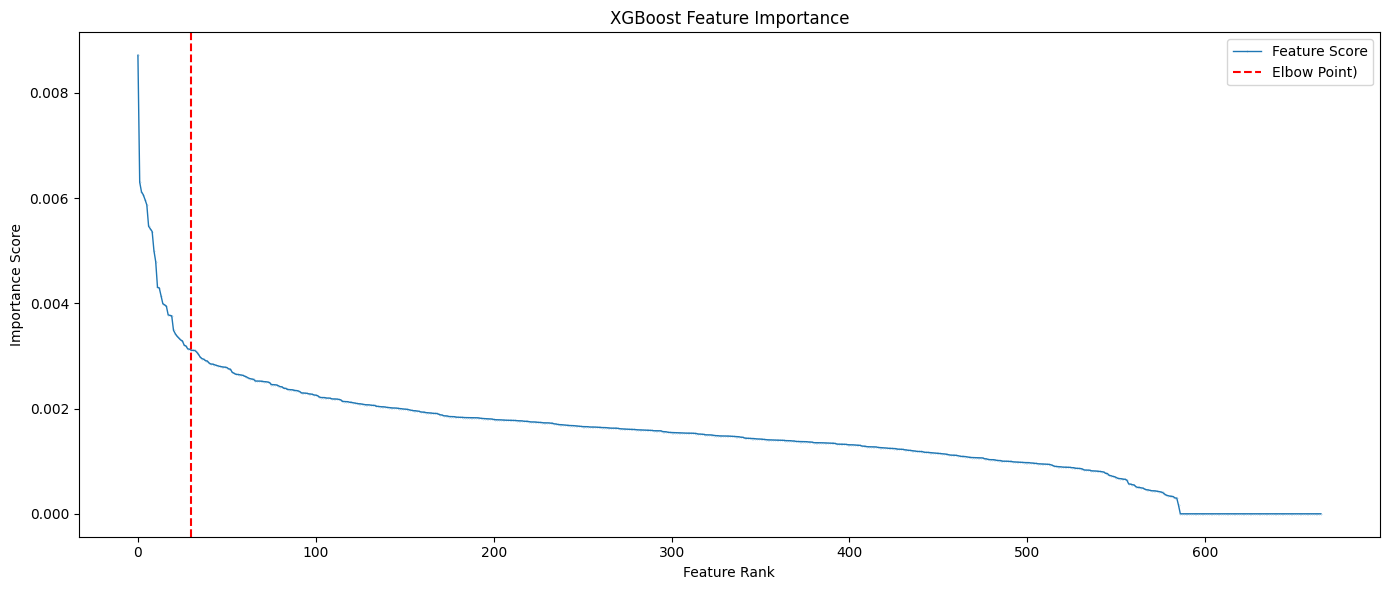

XGB: 0.6360, 30 features
FRegression: 0.6387, 36 features
LASSO: 0.6348, 24 features
Elastic: 0.6357, 27 features
Fold 2


KeyboardInterrupt: 

In [18]:
import numpy as np
import pandas as pd

# 收集統計結果
summary = []

for name, losses in loss_results.items():
    mae_mean = np.mean(losses)
    mae_std = np.std(losses)
    mae_to_std = mae_mean / mae_std if mae_std > 0 else np.inf

    summary.append({
        'Selector': name,
        'MAE Mean': mae_mean,
        'MAE Std': mae_std,
        'MAE Mean / Std': mae_to_std
    })

summary_df = pd.DataFrame(summary).sort_values(by='MAE Mean')
print(summary_df)


      Selector  MAE Mean   MAE Std  MAE Mean / Std
3      Elastic  0.645783  0.010307       62.656174
2        LASSO  0.646263  0.009918       65.161759
1  FRegression  0.646868  0.010789       59.954126
0          XGB  0.646966  0.011948       54.147126


In [20]:
loss_results

defaultdict(list,
            {'XGB': [0.6359703001941601,
              0.6532737056491853,
              0.6617574431409172,
              0.6401009166756243,
              0.6636059953832253,
              0.6598041813035024,
              0.6310162693995321,
              0.6301846987199867,
              0.643561361315721,
              0.6503871906581022],
             'FRegression': [0.6387223915664556,
              0.6548576521479542,
              0.6544121603437043,
              0.6395697881471879,
              0.662017023892903,
              0.660770143125446,
              0.6320318436536277,
              0.630355254752052,
              0.6462713092743096,
              0.6496683065966236],
             'LASSO': [0.6359798573977032,
              0.6503280520924368,
              0.6559936974469878,
              0.6408529956269506,
              0.6612556966155495,
              0.6582894571701723,
              0.6323423812956118,
              0.6339484406635372,
 

In [21]:
from scipy.stats import friedmanchisquare

stat, p = friedmanchisquare(
    loss_results['XGB'],
    loss_results['FRegression'],
    loss_results['LASSO'],
    loss_results['Elastic']
)

print(f"Friedman statistic: {stat:.4f}")
print(f"p-value: {p:.4f}")

if p < 0.05:
    print("✅ 不同模型之間在 MAE 上存在顯著差異")
else:
    print("❌ 不同模型之間在 MAE 上沒有顯著差異")


Friedman statistic: 1.4400
p-value: 0.6962
❌ 不同模型之間在 MAE 上沒有顯著差異


In [22]:
import scikit_posthocs as sp
import pandas as pd

# 組成 df，每欄是模型，每列是 fold
data = pd.DataFrame(loss_results)
sp.posthoc_nemenyi_friedman(data)


,XGB,FRegression,LASSO,Elastic
XGB,1.000000,1.000000,0.985723,0.726349
FRegression,1.000000,1.000000,0.985723,0.726349
LASSO,0.985723,0.985723,1.000000,0.899884
Elastic,0.726349,0.726349,0.899884,1.000000
